In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Type
from torch import nn
from torch.optim import optimizer
import rasterio
import zipfile
from matplotlib import pyplot as plt
import datetime

In [2]:
import os

# --- GPU selection --- #
gpus = 2 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
device = torch.device('cpu')

In [5]:
lidar_image = rasterio.open('../Data/N12/N12_lidar.tif').read()
lidar_array = np.array(lidar_image)

lidar_1n_image = rasterio.open('../Data/N12/N12_lidar_1n.tif').read()
lidar_1n_array = np.array(lidar_1n_image)

lidar_nt_image = rasterio.open('../Data/N12/N12_lidar_nt.tif').read()
lidar_nt_array = np.array(lidar_nt_image)

RGB2020_image = rasterio.open('../Data/N12/N12_RGB2020.tif').read()
RGB2020_array = np.array(RGB2020_image)/255


train_array = np.stack([lidar_array, lidar_1n_array, lidar_nt_array]).squeeze()
train_array = np.concatenate((train_array,RGB2020_array))

In [6]:
target_image = rasterio.open('../Data/N12/N12_newlc.tif').read()
target_array = np.array(target_image, dtype=int).squeeze()
target_array.shape

(2400, 2400)

In [7]:
target_array = np.where(target_array == 1, 0, target_array)
target_array = np.where(target_array == 2, 1, target_array)
target_array = np.where(target_array == 7, 2, target_array)
target_array = np.where(target_array == 8, 3, target_array)
target_array = np.where(target_array == 9, 4, target_array)
target_array = np.where(target_array == 10, 5, target_array)
target_array = np.where(target_array == 11, 6, target_array)

In [9]:
class TrainDataset(Dataset):
    def __init__(self, data_array : Type[np.ndarray], target_array : Type[np.ndarray], patch_size : int):
        self.data = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size), data_array.shape[0], patch_size, patch_size))
        for i in range(0,data_array.shape[1]//patch_size):
            for j in range(0,data_array.shape[2]//patch_size):
                self.data[data_array.shape[1]//patch_size*i+j,:,:,:] = data_array[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] #고치기
                
                #self.data =np.append(self.data, np.zeros(((1, data_array.shape[0], patch_size, patch_size))), axis = 0)
                #self.data = np.concatenate(self.data, np.zeros(((1, data_array.shape[0], patch_size, patch_size))))

        self.label = np.zeros(((data_array.shape[1]//patch_size) * (data_array.shape[2]//patch_size),data_array.shape[0]+1))
        print(self.label.shape)
        
        for k in range(0,data_array.shape[1]//patch_size):
            for l in range(0,data_array.shape[2]//patch_size):
                self.label[data_array.shape[1]//patch_size*k+l,:] = np.bincount(target_array[k*patch_size:(k+1)*patch_size, l*patch_size:(l+1)*patch_size].reshape(-1), minlength=7)/(patch_size*patch_size)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = torch.as_tensor(self.data[idx,:,:,:]).float()
        label = torch.as_tensor(self.label[idx,:]).float()
        return sample, label


# 검증 데이터셋 만들고 데이터로더 구축하기.

In [10]:
N12_Dataset = TrainDataset(data_array=train_array, target_array=target_array, patch_size=20)

batch_size = 120
N12_Dataloader = DataLoader(N12_Dataset, batch_size=batch_size)

(14400, 7)


In [11]:
class UrbanGreenNetwork2(nn.Module):
    def __init__(self):
        super(UrbanGreenNetwork2, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p = 0.2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),
            #nn.Dropout2d(p=0.2),
            nn.ReLU(inplace=True)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(in_features=256, out_features=64),
            nn.Linear(in_features=64, out_features=7)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_block(x)
        return torch.softmax(x, dim=-1)

In [12]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=13, train_rate: float = 0.8, batch_size: int = 60, path:str = '../Data/N12/Model/'): 
    train_loss_history = []
    valid_loss_history = []
    train_patches = int((len(dataloaders.dataset)//batch_size)*train_rate)
    train_range = range(0,train_patches)
    valid_range = range(train_patches, len(dataloaders.dataset)//batch_size)
    patch_size = dataloaders.dataset.data.shape[-1]
    print(f'Dataset length : {len(dataloaders.dataset)}\nTrain range : {train_range}\nValid range : {valid_range}')
    best_model_epoch = 0
    least_valid_loss = 100
    now = datetime.datetime.now()
    zipped_model = zipfile.ZipFile(os.path.join(path, f'{str(now)}.zip'), 'w')
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_running_loss = 0.0
        valid_running_loss = 0.0
        
        
        i = 0
        

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            
            if i in train_range:
                model.train()
                optimizer.zero_grad()
                outputs = model(inputs)
                train_loss = criterion(outputs, labels)
                train_loss.backward(torch.ones_like(train_loss))
                optimizer.step()
                train_running_loss += train_loss.item() * inputs.size(0)
            
            if i in valid_range:
                model.eval()
                outputs = model(inputs)
                valid_loss = criterion(outputs, labels)
                valid_running_loss += valid_loss.item() * inputs.size(0)
                #print('validating')
            i += 1
            #print(f'{i}th batch')

        epoch_train_loss = train_running_loss / train_patches
        epoch_valid_loss = valid_running_loss / (i-train_patches)
        scheduler.step(epoch_valid_loss)

        print('Valid loss: {:.4f}'.format(epoch_valid_loss))
        print('Train loss: {:.4f}'.format(epoch_train_loss))

        if epoch_valid_loss < least_valid_loss:
            least_valid_loss = epoch_valid_loss
            best_model_epoch = epoch

        train_loss_history.append(epoch_train_loss)      
        valid_loss_history.append(epoch_valid_loss)

        torch.save(model.state_dict(), os.path.join(path,'22.07.04/', '{0:0=2d}.pth'.format(epoch)))
        zipped_model.write(os.path.join(path,'22.07.04/', '{0:0=2d}.pth'.format(epoch)))

    plt.figure(figsize=(20,8))
    plt.plot(train_loss_history, 'r-')
    plt.plot(valid_loss_history, 'bo')
    plt.savefig(os.path.join(path,'22.07.04/', 'Tendency.png'), dpi=300)
    zipped_model.write(os.path.join(path,'22.07.04/', 'Tendency.png'))
    zipped_model.writestr('README.txt', f'The best Model : #{best_model_epoch}th model with loss {least_valid_loss}\nOptimizer : {optimizer}\nLoss function : {criterion}\nBatch size : {batch_size}\nScheduler : {scheduler}\nPatch size : {patch_size}\nTotal epochs : {num_epochs}\nModel information :\n{model.modules}')
    
    print('Best loss: {:4f}, in Epoch #{:0=3d}'.format(least_valid_loss, best_model_epoch))    
    zipped_model.close()
    return train_loss_history, valid_loss_history

Dataset length : 14400
Train range : range(0, 96)
Valid range : range(96, 120)
Epoch 0/99
----------
Valid loss: 8.6348
Train loss: 10.3335
Epoch 1/99
----------
Valid loss: 6.4567
Train loss: 8.8105
Epoch 2/99
----------
Valid loss: 7.2931
Train loss: 7.3100
Epoch 3/99
----------
Valid loss: 5.8961
Train loss: 6.3956
Epoch 4/99
----------
Valid loss: 5.3844
Train loss: 5.7251
Epoch 5/99
----------
Valid loss: 4.8602
Train loss: 5.2458
Epoch 6/99
----------
Valid loss: 4.0600
Train loss: 4.8738
Epoch 7/99
----------
Valid loss: 3.6650
Train loss: 4.5450
Epoch 8/99
----------
Valid loss: 3.9201
Train loss: 4.4742
Epoch 9/99
----------
Valid loss: 3.6863
Train loss: 4.3128
Epoch 10/99
----------
Valid loss: 3.5559
Train loss: 4.2602
Epoch 11/99
----------
Valid loss: 3.5419
Train loss: 4.2238
Epoch 12/99
----------
Valid loss: 3.6060
Train loss: 4.1678
Epoch 13/99
----------
Valid loss: 3.6114
Train loss: 4.1232
Epoch 14/99
----------
Valid loss: 3.6361
Train loss: 4.0804
Epoch 15/99
---

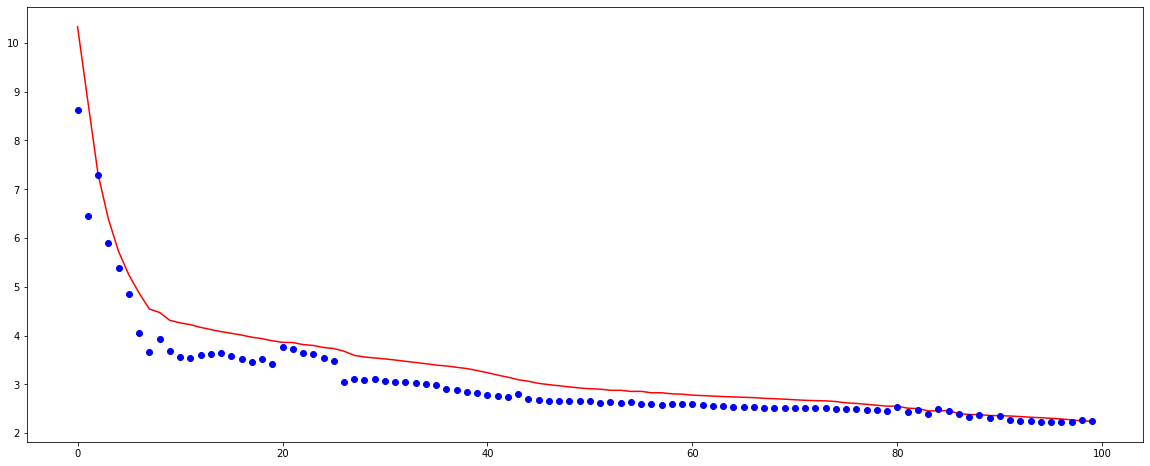

In [13]:
model2 = UrbanGreenNetwork2()
criterion2 = torch.nn.MSELoss(reduction='mean')
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', patience=5, factor=0.75)
train_loss_hist2, valid_loss_hist2 = train_model(model2, N12_Dataloader, criterion2, optimizer2, scheduler2, device, num_epochs=100, batch_size=batch_size, path='../Data/N12/Model/patch_20/')

In [14]:
best_model = UrbanGreenNetwork2()
best_model.load_state_dict(torch.load('../Data/N12/Model/patch_20/22.07.04/95.pth'))

<All keys matched successfully>

In [15]:
best_model.modules

<bound method Module.modules of UrbanGreenNetwork2(
  (conv_block_1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=7, bias=True)
  )
)>

In [76]:
prediction = np.zeros((120,120,7))
for i, (data, index) in enumerate(N12_Dataloader):
    prediction[i, :, :] = best_model(data).detach().numpy()

In [80]:
prediction_expanded = np.zeros((7,2400,2400))
for i in range(120):
    for j in range(120):
        for k in range(7):
            prediction_expanded[k,i*20:(i+1)*20, j*20:(j+1)*20] = prediction[i,j,k]

        #print(f'Sum : {prediction[i,j,:].sum()}')

In [81]:
reference_image = rasterio.open("../Data/N12/N12_intensity.tif")

In [82]:
for i in range(prediction_expanded.shape[0]):   
    processed_tiff = rasterio.open(
        f'../Data/N12/Model/patch_20/22.07.04/result{i}_of_second_net_RGB_normalized.tif',
        'w',
        driver='GTiff',
        height=prediction_expanded.shape[1],
        width=prediction_expanded.shape[2],
        count=1,
        dtype=prediction_expanded.dtype,
        crs=reference_image.crs,
        transform=reference_image.transform,
    )
    processed_tiff.write(prediction_expanded[i,:,:],1)
    processed_tiff.close()

In [ ]:
'''def save_result(model: Type[nn.Module], dataloader : Type[DataLoader], path:str):
    zipped_results = zipfile.ZipFile(path+f'RESULT_{str(datetime.datetime.now())}'+'.zip', 'w')
    prediction = np.zeros((60,60,12))
    for i, (data, index) in enumerate(dataloader):
        prediction[i, :, :] = best_model(data).detach().numpy()
    
    for j in range(prediction.shape[-1]):
        plt.imsave(path+f'/{j}th_index.png', prediction[:,:,j])
        zipped_results.write(path+f'/{j}th_index.png', f'/{j}th_index.png')
    zipped_results.close()
    return path+f'RESULT_{str(datetime.datetime.now())}'+'.zip'
save_result(best_model, N12_Dataloader, path=os.path.join('../Data/N12/Model/patch_40/','22.07.04/'))'''